# CSE 541 HW 2

## Problem 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### part (1)

In [12]:
sigmas = [10**(-int(k)) for k in np.arange(0, 7).astype(int)]

In [30]:
delta = 0.05
ts = list(range(1, 10**6))
hoeffding_bounds = np.asarray([np.sqrt(2 * np.log(2/delta) / t) for t in ts])
anytime_bounds = {
    sigma: np.asarray([np.sqrt(1 + 1 / sigma / t) * np.sqrt((2 * np.log(1/delta) + np.log(t * sigma + 1))/ t) for t in ts])
    for sigma in sigmas
}

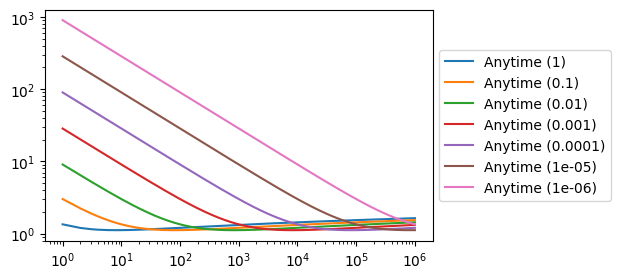

In [33]:
plt.figure(figsize=(5,3))
for sigma in sigmas:
    plt.plot(ts, anytime_bounds[sigma] / hoeffding_bounds, label=f"Anytime ({sigma})")
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### part (2)

In [52]:
d = 10
N = 1000

In [69]:
def h(X, A):
    Ainv = np.linalg.inv(A)
    return np.max([x.T @ Ainv @ x for x in X])

def greedy(X, N):
    n, d = X.shape
    It = np.random.choice(n, size=2*d, replace=True)
    # lam = np.zeros(n)
    # for i in It:
    #     lam[i] += 1
    # lam / (2 * d)
    S = X[It].T @ X[It] / (2 * d)
    
    for i in range(2*d, N):
        Isel = np.argmin([h(X, S + np.outer(X[k], X[k])) for k in range(n)])
        It = np.append(It, Isel)
        
    return It


def frank_wolf(X, N):
    n, d = X.shape
    It = np.random.choice(n, size=2*d, replace=True)
    S = X[It].T @ X[It] / 2 / d
    
    for i in range(2*d, N):
        A_inv = np.linalg.inv(S)
        norms = np.sum(X @ A_inv * X, axis=1)  # list of ||x_i||_{A_\lambda^{-1}}
        Isel = np.argmax(norms)  # min of negative
        It = np.append(It, Isel)
        eta = 2 / (i+2)
        S = (1 - eta) * S + eta * np.outer(X[Isel], X[Isel])
        
    return It

In [ ]:
alphas = [0, 0.5, 1, 2]
Xfull = np.random.normal(0, 1, size = (N, d))
n_range = [20, 100, 500, 1000]

results = {alpha : [] for alpha in alphas}

for alpha in alphas:
    X = Xfull @ np.diag([i**(-alpha / 2) for i in range(1, d+1)])
    for n in n_range:
        indices = greedy(X[:n])
        
        lam = np.zeros(n)
        for i in indices:
            lam[i] += 1 / N
        A = X[:n].T @ np.diag(lam) @ X[:n]
        
        results[alpha].append(h(X[:n], A))

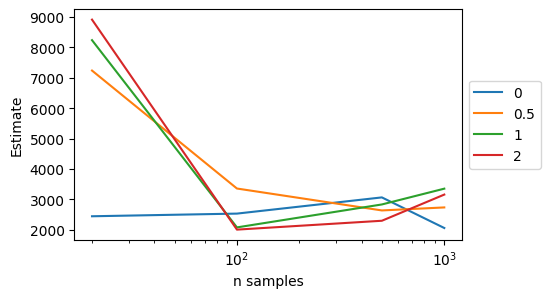

In [60]:
plt.figure(figsize=(5,3))
for alpha in alphas:
    plt.plot(n_range, results[alpha], label=f"{alpha}")
# plt.yscale('log')
plt.xscale('log')
plt.xlabel("n samples")
plt.ylabel("Estimate")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [82]:
alphas = [0, 0.5, 1, 2]
Xfull = np.random.normal(0, 1, size = (N, d))
n_range = [10 + 2**(i+1) for i in range(10)]
# n_range = [12, 100]

results = {alpha : [] for alpha in alphas}

for alpha in alphas:
    X = Xfull @ np.diag([i**(-alpha / 2) for i in range(1, d+1)])
    for n in n_range:
        indices = frank_wolf(X[:n], N)
        
        A = X[indices].T @ X[indices] / len(indices)
        
        results[alpha].append(-np.log(np.linalg.det(A)))

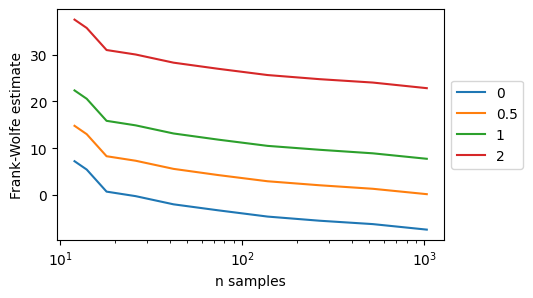

In [83]:
plt.figure(figsize=(5,3))
for alpha in alphas:
    plt.plot(n_range, results[alpha], label=f"{alpha}")
# plt.yscale('log')
plt.xscale('log')
plt.xlabel("n samples")
plt.ylabel("Frank-Wolfe estimate")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Part 5c

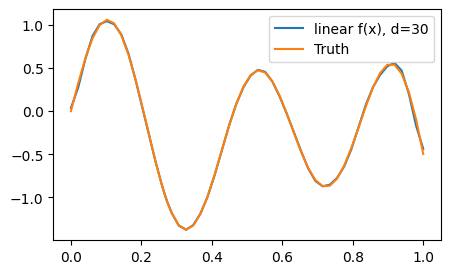

In [ ]:
n = 300
X = np.concatenate((np.linspace(0, 1, 50), 0.25 + 0.01 * np.random.randn(250)), 0)
X = np.sort(X)
K = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        K[i, j] = 1 + min(X[i], X[j])
e, v = np.linalg.eigh(K)  # eigenvalues are increasing in order
d = 30
Phi = np.real(v @ np.diag(np.sqrt(np.abs(e))))[:, (n - d) : :]

def f(x):
    return -(x**2) + x * np.cos(8 * x) + np.sin(15 * x)

f_star = f(X)
theta = np.linalg.lstsq(Phi, f_star, rcond=None)[0]
f_hat = Phi @ theta

plt.figure(figsize=(5,3))
plt.plot(X, f_hat, label='linear f(x), d=30')
plt.plot(X, f_star, label="Truth")
plt.legend()
plt.show()

In [112]:
def observe(idx):
    return f(X[idx]) + np.random.randn(len(idx))


def sample_and_estimate(X, lbda, tau):
    n, d = X.shape
    reg = 1e-6  # we can add a bit of regularization to avoid divide by 0
    idx = np.random.choice(np.arange(n), size=tau, p=lbda)
    y = observe(idx)

    XtX = X[idx].T @ X[idx]
    XtY = X[idx].T @ y

    theta = np.linalg.lstsq(XtX + reg * np.eye(d), XtY, rcond=None)[0]
    return Phi @ theta, XtX


T = 1000
indices = frank_wolf(Phi, T)
lbda = np.zeros(Phi.shape[0])
for i in indices:
    lbda[i] += 1
lbda /= sum(lbda)

f_G_Phi, A = sample_and_estimate(Phi, lbda, T)
conf_G = np.sqrt(np.sum(Phi @ np.linalg.inv(A) * Phi, axis=1))

lbda_unif = np.ones(n) / n
f_unif_Phi, A = sample_and_estimate(Phi, lbda_unif, T)
conf_unif = np.sqrt(np.sum(Phi @ np.linalg.inv(A) * Phi, axis=1))

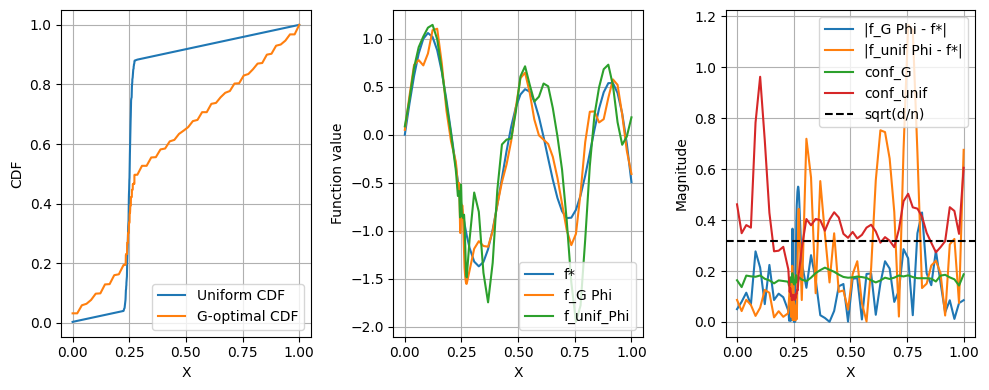

In [114]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

axes[0].plot(X, np.cumsum(lbda_unif), label="Uniform CDF")
axes[0].plot(X, np.cumsum(lbda), label="G-optimal CDF")
axes[0].set_ylabel("CDF")
axes[0].set_xlabel("X")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(X, f_star, label="f*")
axes[1].plot(X, f_G_Phi, label="f_G Phi")
axes[1].plot(X, f_unif_Phi, label="f_unif_Phi")
axes[1].set_ylabel("Function value")
axes[1].set_xlabel("X")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(X, np.abs(f_G_Phi - f_star), label="|f_G Phi - f*|")
axes[2].plot(X, np.abs(f_unif_Phi - f_star), label="|f_unif Phi - f*|")
axes[2].plot(X, conf_G, label="conf_G")
axes[2].plot(X, conf_unif, label="conf_unif")
axes[2].axhline(np.sqrt(d / n), ls='--', label="sqrt(d/n)", color="black")
axes[2].set_xlabel("X")
axes[2].set_ylabel("Magnitude")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

### Part 5d

In [123]:
n = 300
X = np.concatenate((np.linspace(0, 1, 50), 0.25 + 0.01 * np.random.randn(250)), 0)
X = np.sort(X)
K = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        K[i, j] = 1 + min(X[i], X[j])
e, v = np.linalg.eigh(K)  # eigenvalues are increasing in order
d = 30
Phi = np.real(v @ np.diag(np.sqrt(np.abs(e))))[:, (n - d) : :]

def f(x):
    return -(x**2) + x * np.cos(8 * x) + np.sin(15 * x)

def observe(indices):
    return f(X[indices]) + np.random.randn(len(indices))

In [169]:
def elimination(X, T, tau=100, gamma=1, U=1, fw_samples=1000):
    _, d = X.shape
    delta = 1 / T
    V = gamma * np.eye(d)
    S = 0
    X_hat = X
    rewards = []
    
    for _ in range(int(np.floor(T / tau))):
        lmbda = frank_wolf(X_hat, fw_samples)
        indices = np.random.choice(lmbda, size=tau, replace=True)
        Y = observe(indices)
        V += X_hat[indices].T @ X_hat[indices]
        V_inv = np.linalg.inv(V)
        S += X_hat[indices].T @ Y
        theta = V_inv @ S
        beta = np.sqrt(gamma) * U + np.sqrt(2 * np.log(1 / delta) + np.log(np.linalg.det(V / gamma)))
        x_hat = np.argmax(X_hat @ theta)
        diff = X_hat - x_hat
        keep = (diff @ theta) < (beta * np.sqrt(np.sum(diff @ V_inv * diff, axis=1)))
        X_hat = X_hat[keep]
        rewards.append(Y)
        
    return np.concatenate(rewards)

def UCB(X, T, gamma=1, U=1):
    _, d = X.shape
    delta = 1 / T
    V = gamma * np.eye(d)
    S = np.zeros(d)
    rewards = []
    
    for _ in range(T):
        beta = np.sqrt(gamma) * U + np.sqrt(2 * np.log(1 / delta) + np.log(np.linalg.det(V / gamma)))
        V_inv = np.linalg.inv(V)
        theta = V_inv @ S
        index = np.argmax(X @ theta + beta * np.sqrt(np.sum(X @ V_inv * X, axis=1)))
        Y = observe([index])
        rewards.append(Y)
        V += np.outer(X[index], X[index])
        S += X[index] * Y
        
    return np.concatenate(rewards)


def thompson_sampling(X, T, gamma=1, U=1):
    _, d = X.shape
    V = gamma * np.eye(d)
    S = np.zeros(d)
    rewards = []
    
    for _ in range(T):
        V_inv = np.linalg.inv(V)
        theta = V_inv @ S
        theta_sample = np.random.multivariate_normal(theta, V_inv)
        index = np.argmax(X @ theta_sample)
        Y = observe([index])
        rewards.append(Y)
        V += np.outer(X[index], X[index])
        S += X[index] * Y
        
    return np.concatenate(rewards)

In [170]:
T = 40000
elim_rewards = elimination(Phi, T)
ucb_rewards = UCB(Phi, T)
ts_rewards = thompson_sampling(Phi, T)

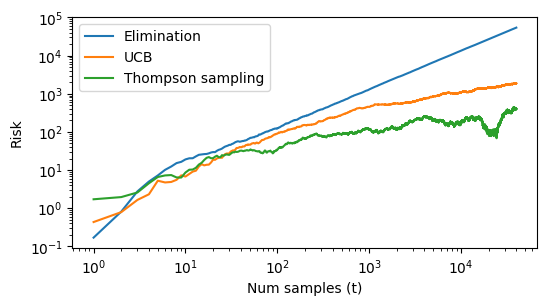

In [171]:
max_reward = max(f(X))
T_range = np.arange(1, T+1)

plt.figure(figsize=(6,3))
plt.plot(T_range, T_range * max_reward - np.cumsum(elim_rewards), label=f"Elimination")
plt.plot(T_range, T_range * max_reward - np.cumsum(ucb_rewards), label=f"UCB")
plt.plot(T_range, T_range * max_reward - np.cumsum(ts_rewards), label=f"Thompson sampling")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Num samples (t)")
plt.ylabel("Risk")
plt.legend()
plt.show()